In [37]:
import os
import glob
import json
import requests
import io
from PIL import Image
import time
from transformers import AutoImageProcessor, MobileViTV2Model
import torch

In [13]:
sample_data = [
    json.load(open(el))
    for el in glob.glob("sample_data/*")
]

In [15]:
urls = []
for el in sample_data:
    if "url" in el:
        urls.append(el["url"])

In [17]:
urls

163

In [25]:
def get_image(url):
    if not url.endswith((".jpg", ".jpeg", ".png", ".webp")):
        return None
    if url[:5] == "gs://":
        url_trimmed = url.replace("gs://", "")
        bucket_name, blob_name = url_trimmed.split("/", 1)
        storage_client = storage.Client()
        
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(blob_name)
        result = blob.download_as_bytes()
        contents = io.BytesIO(result)
    else:
        contents = requests.get(url, stream=True).raw
    
    image = PIL.Image.open(contents)
    return image   

In [35]:
images = []
for url in urls:
    images.append(
        get_image(url)
    )
    time.sleep(1)
    print(url, end="\r")

In [49]:
image_processor = AutoImageProcessor.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")
model_vit = MobileViTV2Model.from_pretrained("apple/mobilevitv2-1.0-imagenet1k-256")

In [48]:
def process_vit(image):
    try:
        inputs = image_processor(image, return_tensors="pt")
        with torch.no_grad():
            outputs = model_vit(**inputs)
        embeddings = outputs.pooler_output.tolist()[0]
        return embeddings 
    except Exception:
        return 

In [44]:
embeddings = []
for image in images:
    embedding = process_vit(image)
    if embedding is not None:
        embeddings.append(embedding)

In [47]:
import numpy as np

In [51]:
from sklearn.cluster import Birch
from sklearn.metrics import silhouette_score

In [53]:
np.array(embeddings).shape

(106, 512)

In [ ]:
silhouettes = []
for n_clusters in range(2, 101):
    m = Birch(n_clusters=n_clusters)
    y = []
    for emb in embeddings:
        m.partial_fit(np.array([emb]))
        y.append(
            m.predict(np.array([emb]))[0]
        )
    sil = silhouette_score(np.array(embeddings), y)
    silhouettes.append(sil)

In [70]:
import matplotlib.pyplot as plt

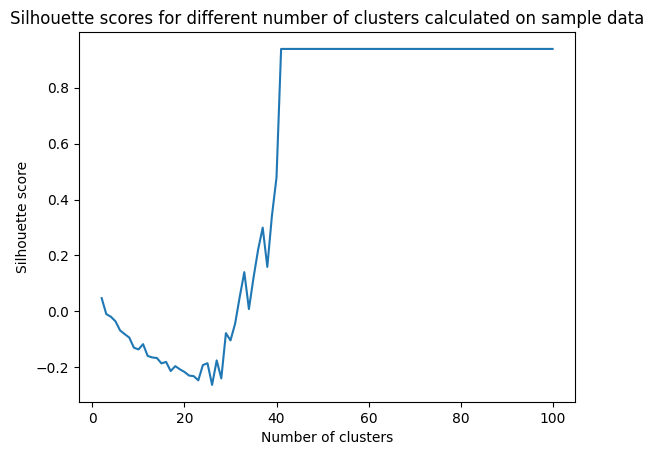

In [77]:
plt.plot([i for i in range(2, 101)], silhouettes)
plt.title("Silhouette scores for different number of clusters calculated on sample data")
plt.ylabel("Silhouette score")
plt.xlabel("Number of clusters")
plt.show()

In [76]:
max(y) + 1

40